# Condescenscion Detection in Reddit Posts

---

# Executive Summary

Condecenscion is defined as "an attitude of patronizing superiority; disdain". It is also insulting, and so we would like to create a model that can detect it automatically (to reduce the amount of work that a human has to do). I also tried to research condecenscion but wasn't able to find a lot, so another goal of this project is to try and quantify condescending behavior.

The corpus of text I am using is a labelled set of 5000 Reddit post & reply pairs, from researchers Zijian Wang and Christopher Potts. The posts were sorted into 'condescending' and 'not condescending' by human readers.

The first thing that I did after cleaning the data was to use a simple model to try and predict condecenscion. This was reasonably effective, and we were able to find some things:
- The best way to predict if someone is condescending, is if the reply contains the word 'condescending' or an insulting word (e.g. f\*\*k)
- Without looking at the reply, simple models like logistic regression have a hard time determining whether text is condescending or not.

Based on these findings, I decided to use a pre-trained language model (BERT) to analyze the meanings/embeddings of the post and reply. It turns out that when someone is condescending, replies to them will have a noticeable change in the topic, so this is another good way to detect condecenscion (if there is a reply).

In addition, we found that sentiments commonly associated with being condescending also show up a lot in **replies** to the condescending post, suggesting that if someone is condescending, the reply will be even more condescending.

Finally, I tried to group condescending posts/replies into groups but it seems that there aren't any clear groupings.

Based on the above, we were able to find more things about condescenscion.
- If someone is condescending, this means it's more likely that the reply is also condescending. This means that condecenscion is a reply to other people being condescending (i.e. it's a vicious cycle)
- There only seems to be one category of condescension (wasn't able to group it into different categories)

Finally, I tried to use transfer learning + BERT to see if a model can detect condescending text without looking at the reply. This has around 70% AUC ROC which is better than the other models tried previously. However it still ends up with a good amount of false negatives.

In conclusion, if we have access to the reply we can predict if someone is being condescending quite accurately. However without the reply (the more general case) it is harder. We were able to identify some features of condescending text such as that it is a vicious cycle and also certain words that are more condescending (such as "lol", "sell", and "obvious").

---

# Contents

1. [Problem Statement](#problem_statement)
2. [Data Source](#data_source)
3. [EDA](#eda)
4. [Word Clouds](#word_clouds)
5. [Basic Model](#basic_model)



---

# Problem Statement <a id='problem_statement'></a>
Condescenscion is a difficult thing to quantify. A general definition is "an attitude of patronizing superiority; disdain" (Oxford Languages). However, it's hard to pinpoint exactly which factors make someone's words condescending, and there isn't much research in this area too.

Based on this, I would like to do 2 things:
1) Try to identify common behaviors among condescending speech
2) Create a model that can identify someone who is being condescending.

To explain more about the model, I want to create a binary classification model that detects if someone is being condescending in Reddit posts. The performance is determined by the accuracy and AUC/ROC curve.

The model will classify a post as either condescending or not, ideally with a probability attached to this classification. The exact type of model depends on what works best, although it could range from a simple logistic regression all the way to a neural network.

I will judge the performance of the model using accuracy: this is because a balanced training set is provided in the data. However, I will also use the model on imbalanced data (to simulate actual Reddit posts), and for this I will use ROC AUC metric as well.

### Why do we want to know this?
It's difficult for traditional models to detect condescenscion (per the creators of the corpus) since it depends on the context. This means that moderators of these posts have to manually look through each post and decide themselves, which is time consuming and maybe subjective to individual biases.

Therefore if a model is able to predict this, it will save a lot of time. Depending on how the model functions it may also be able to detect other 'bad' behavior such as being threatening or dismissive.

# Data Source <a id='data_source'></a>
 A corpus of condescending posts can be found [here](https://github.com/zijwang/talkdown). The corpus of text contains a Reddit post (the parent, and the post we want to classify), as well as a post responding to it (the child). This is scraped directly from Reddit although it is provided in a json format. The posts are also labelled as condescending vs not.
 
The data is provided in 2 forms: a balanced train/test set as well as an imbalanced set. For now, I will just look at the balanced set since it's simpler to work with (no imbalanced classes).


Risks and Assumptions:
- Whether something is condescending depends on the reader. I will stick to the provided labels because the rating was collected using Amazon Mechanical Turk, which gets results from multiple people so it should be more accurate.
- Source mentions that the data was initially collected by looking for a condescenscion related word. It is possible that there are many condescending posts out in the wild that do not fit this category. The model therefore wouldn't help to detect these (or at least, it won't work as well) so that could be a problem.
- The data only contains posts that have a reply so if we use that, it won't work in all cases.
- Per the creators of the corpus, the corpus is limited to posts in which a reply contains a quote of the parent post. Again this might skew the results but I don't know by how much.

### Proposed Methods
- First, conduct EDA on the data to identify if there is anything that is particularly condescending. Maybe I can use feature engineering to add this in as an additional feature. This step will take the longest as most of the data comes in raw text form.
    - This also includes trying to establish links between the parent post and the child post.
    - Also research what condescenscion is, and how people express it, as that can help identify features.
- Second, vectorize the words. This sort of assumes we are using a bag of words approach. As of right now I am not familiar with other methods of text classification so maybe this step isn't necessary.
- Finally, try a model and interpret the results, to see what the model was looking for. Repeat steps 1 and 2 until the model is accurate enough.

## Other Stakeholders
- Social media moderators who either want a program that can detect condescension automatically, or figure out how to couteract it
- Social scientists studying condescension


# EDA <a id='eda'></a>

Here are some things I want to check out:
- how long is each post on average?
- What are some common condescending speech patterns?
- How often does condescension appear in general?
- Can I identify some simple things that are condescending?

In [1]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# imports for the basic model at the bottom
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# read balanced data set
cond_df = pd.read_json('./cond_data/balanced_train.jsonl', lines=True)
cond_df.head()

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp
2,If I try and force down a breakfast I start ga...,Yes!\n\nPeople were so condescending about it ...,False,For me it's like temporarily having the flu. T...,> If I try and force down a breakfast I start ...,amphetaminesfailure,CowGiraffe,331,383,cuv97mf,cuvnb27
3,Nonviolence leads to reform and progress. It's...,"I don't believe you, you provide no examples, ...",True,"Uh, no. Nonviolence leads to reform and progre...",>Nonviolence leads to reform and progress. It'...,UmamiSalami,ArizonaIcedOutBoys,8,102,cmb6odf,cmbb0la
4,Have you actually read the bible ??,Is that where you learned how to be condescend...,True,>Do you not understand how insensitive and rud...,> Have you actually read the bible ??\n\nIs th...,lju1977,katapliktikos,58,93,cqq300a,cqq3289


### Check that data is ok

In [4]:
# Data types
cond_df.dtypes

quotedpost         object
quotedreply        object
label                bool
post               object
reply              object
post_user          object
reply_user         object
start_offset        int64
end_offset          int64
reddit_post_id     object
reddit_reply_id    object
dtype: object

Seems normal, it's text data so most of the columns are object.

In [5]:
# Missing data:
cond_df.isna().sum()

quotedpost         0
quotedreply        0
label              0
post               0
reply              0
post_user          0
reply_user         0
start_offset       0
end_offset         0
reddit_post_id     0
reddit_reply_id    0
dtype: int64

No missing data, this is good.

Figure out what each column means as it's a bit ambiguous. Print a few entries (I picked ones that weren't too long).

In [6]:
# Figure out what each column means
# I really should have used a function for this
print("\nquotedpost")
print(cond_df.iloc[0,0])

print("\nquotedreply")
print(cond_df.iloc[0,1])

print("\npost")
print(cond_df.iloc[0,3])

print("\nreply")
print(cond_df.iloc[0,4])

print("-"*10)

print("\nquotedpost")
print(cond_df.iloc[2,0])

print("\nquotedreply")
print(cond_df.iloc[2,1])

print("\npost")
print(cond_df.iloc[2,3])

print("\nreply")
print(cond_df.iloc[2,4])


quotedpost
Please educate yoyrself before you bring your opinions on this subreddit.

quotedreply
Not condescending at all, jeez.

post
Well a guy is saying Barra, who has those great credentials, sucks... It is just so rude an misinformed to say a guy like Barra sucks. Please educate yoyrself before you bring your opinions on this subreddit.

reply
> Please educate yoyrself before you bring your opinions on this subreddit.

Not condescending at all, jeez.
----------

quotedpost
If I try and force down a breakfast I start gagging.

quotedreply
Yes!

People were so condescending about it when I got my first job out of college. It was 40 minutes away from home and I had to be there at 7:30. They would go on and on about how I'll "get used to it". But it has been a few years now and I'm not used to it (new job is much closer to home, and pretty relaxed about me getting there anytime before 8:30).

I've gotten BETTER, sure. I generally wake up around 8 on weekends, whereas I used to never

---

By looking at the paper which the source came from, as well as the two entries above, we can identify what the columns mean.
- post: the entire parent post (what we want to classify)
- reply: the reply to the parent post (which we use to help classify the parent post)
- quotedpost: part of the parent post that was quoted in the reply. The idea is that the reply accuses the parent post of being condescending by quoting them and this is the part that was quoted.
- quotedreply: the part of the child/reply post that directly responds to the quoted post by saying they are condescending.

In other words, the two 'quoted' columns are basically feature engineered columns from the 'post' and 'reply' columns.

# EDA
I want to see if the word 'condescending' (or 'condescenscion'.etc) is related to being condescending. It seems reasonable that a condescending post will have someone replying 'don't be condescending'. This probably won't be perfect but I just want to find out.

In [7]:
import regex as re

In [8]:
# add a new column
# probably could use lambda function
# but this is easier to read
def has_cond(text):
    
    if "condesc" in text:
        return 1
    else:
        return 0
    
cond_df["has_cond"] = cond_df["reply"].map(has_cond)
cond_df.head()

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id,has_cond
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj,1
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp,1
2,If I try and force down a breakfast I start ga...,Yes!\n\nPeople were so condescending about it ...,False,For me it's like temporarily having the flu. T...,> If I try and force down a breakfast I start ...,amphetaminesfailure,CowGiraffe,331,383,cuv97mf,cuvnb27,1
3,Nonviolence leads to reform and progress. It's...,"I don't believe you, you provide no examples, ...",True,"Uh, no. Nonviolence leads to reform and progre...",>Nonviolence leads to reform and progress. It'...,UmamiSalami,ArizonaIcedOutBoys,8,102,cmb6odf,cmbb0la,1
4,Have you actually read the bible ??,Is that where you learned how to be condescend...,True,>Do you not understand how insensitive and rud...,> Have you actually read the bible ??\n\nIs th...,lju1977,katapliktikos,58,93,cqq300a,cqq3289,1


In [9]:
# See if the column has any relationship to being condescending
from scipy.stats import pearsonr

pearsonr(cond_df["has_cond"], cond_df["label"])

(0.5599832832968206, 0.0)

We can see that there actually is a pretty strong correlation, so this means it's possible to (somewhat accurately) detect condescenscion just from the presence of the word alone. Not perfect but it's a start.

### Sentence Lengths:
Was curious about this so just did a quick check.

In [10]:
# Add in a new column showing the sentence length

def num_words(text):
    
    split_text = text.split()
    return len(split_text)

cond_df["post_len"] = cond_df["post"].map(num_words)
cond_df["reply_len"] = cond_df["reply"].map(num_words)
print("done")

done


Text(0, 0.5, 'Distribution')

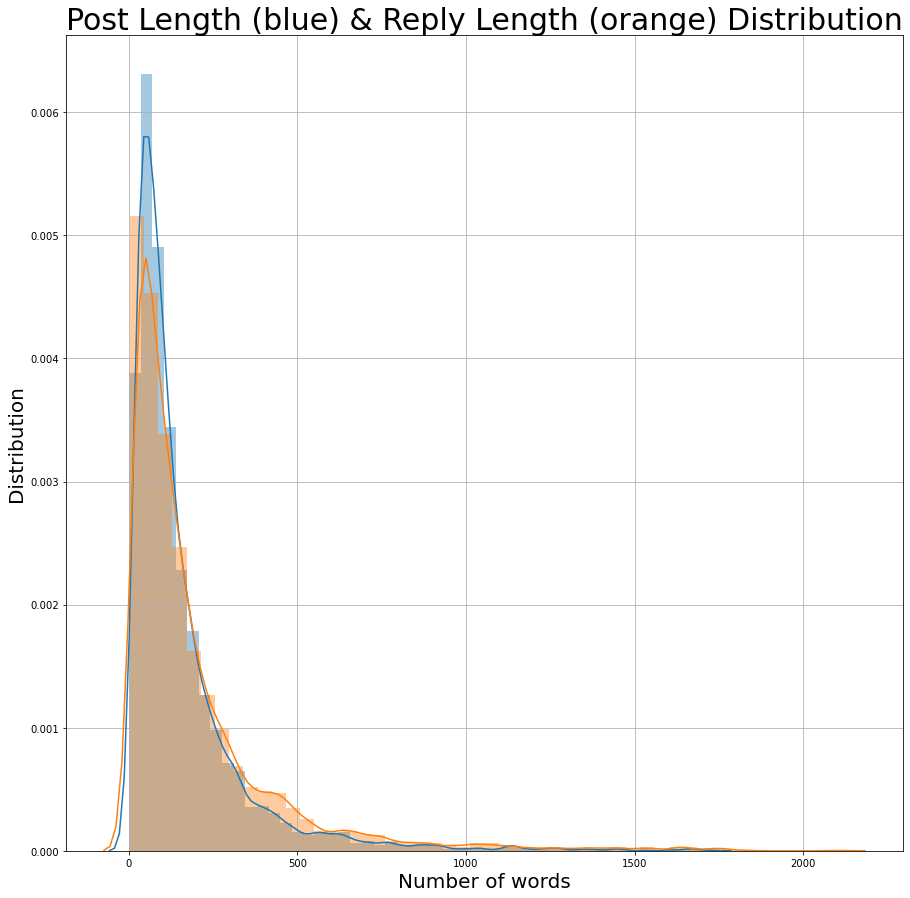

In [11]:
plt.figure(figsize=(15,15))
plt.grid()
sns.distplot(cond_df["post_len"])
sns.distplot(cond_df["reply_len"])

plt.title("Post Length (blue) & Reply Length (orange) Distribution", fontsize=30)
plt.xlabel("Number of words", fontsize=20)
plt.ylabel("Distribution", fontsize=20)

Most are around a similar length but there's a few really long posts. I guess since we have this column, it's worth checking out whether it's correlated

In [13]:
# correlation with post length
pearsonr(cond_df["post_len"], cond_df["label"])

(0.05919754583799789, 1.913075044216428e-05)

In [14]:
# corr with reply length
pearsonr(cond_df["reply_len"], cond_df["label"])

(0.10146304054515597, 2.1452310668167938e-13)

So there's maybe a bit of correlation, but not a lot.

## Research on condescenscion


As mentioned in the introduction, there is not a lot of research into things that make someone condescending other than their general attitude. Here is another definition:

[Condescension](https://dictionary.cambridge.org/dictionary/english/condescension): Behaviour that shows you think you are more important or more intelligent than other people:
- He looked at me with condescension and pity in his eyes.
- She answered him with such haughty condescension that his face went white.

Since there aren't a lot of things that can tell me, I will just do some EDA.

## Word Clouds <a id='word_clouds'></a>
In the absence of any other source to go on, I will put the data into word clouds and see what the most popular words are:

In [15]:
# filter the data by condescending vs not
is_condescending = cond_df[cond_df["label"] == True]["post"]
is_not_condescending = cond_df[cond_df["label"] == False]["post"]

In [16]:
# export to CSV and upload to website
is_condescending.to_csv("./cond_data/for_wordcloud/is_condescending.csv", index=False)
is_not_condescending.to_csv("./cond_data/for_wordcloud/is_not_condescending.csv", index=False)

The thumbs down one is condescending, while the thumbs up one is not.

 # Words in Condescending Posts
 <img src="./other_files/condescending_wordcloud.png" alt="Condescending Word Cloud"> 

 # Words in Non Condescending Posts
 <img src="./other_files/not_condescending.png" alt="Not Condescending Word Cloud"> 

As we can see it is quite similar. Both of them have the words 'people' as the most common, followed by 'like', 'just', 'think', 'know, 'can', 'get', 'one'.etc. This means that using a traditional bag of words approach won't work (although, this doesn't take into account n-grams).

## Reply
Next we can make word clouds of the replies (where people accuse the poster of being condescending). Hopefully this is more different.

In [17]:
# filter the data by condescending vs not
is_condescending = cond_df[cond_df["label"] == True]["reply"]
is_not_condescending = cond_df[cond_df["label"] == False]["reply"]

In [18]:
# export to CSV and upload to website
is_condescending.to_csv("./cond_data/for_wordcloud/is_condescending_reply.csv", index=False)
is_not_condescending.to_csv("./cond_data/for_wordcloud/is_not_condescending_reply.csv", index=False)

 ## Replies to condescending posts
 <img src="./other_files/condescending_reply.png" alt="Replies to Condescending Posts"> 

 # Replies to non-condescending posts
 <img src="./other_files/not_condescending_reply.png" alt="Replies to non condescending posts"> 

We can see that the most popular word in replies to a condescending post is 'condescending'. This makes sense since they are accusing the speaker of being condescending. However we can see that the word 'condescending' is also quite frequent in the non-condescending posts. We can see some examples here:

In [19]:
# posts that are NOT condescending, but the reply has the word 'condescending in it'

def show_row(row_num):
    print("---Post---")
    print(cond_df[(cond_df["label"] == False)
        & (cond_df["reply"].str.contains("condescending"))][["post", "reply"]].iloc[row_num, 0])
    
    print("\n---Reply---")
    print(cond_df[(cond_df["label"] == False)
        & (cond_df["reply"].str.contains("condescending"))][["post", "reply"]].iloc[row_num, 1])
    print("-" * 15)

In [20]:
# print out 5 random lines (note: I ran this quite a few times to read different samples)
[show_row(random.randint(0,100)) for _ in range(5)]

---Post---
>Semantics. Yukino is certainly a negative nancy. Disputing only the "always" point doesn't actually help your overall case.

Disputing the "always" was my way to ask for something more concrete because you were being vague. I'm not interested in arguing about semantics. 


What was the point of sticking in the word "only", by the way? I'm not strawmaning here.

>Except she's not just being reserved. She absolutely represses emotions even towards her own family. 

Yukino is simply more reserved than usual..? I don't know what else to tell you man. 


Her stern mom doesn't make things easy either.

>Case in point look at her older sister. 

Her sister happens to be more outgoing. That's it really. 

>She could make friends easily if she tried to. 

Again, she's not very outgoing, more of an introvert, tendency to be blunt, kinda awkward, etc. It's not easy for everyone.
>She doesn't understand that she doesn't have any friends because oftentimes she's toxic as fuck. 

Example

[None, None, None, None, None]

## Findings:
- Posts that are not condescending can still be rude (although not necessarily).
- Some of the posts classified as 'not condescending' seem pretty condescending to me but I will trust the results from the source as they were collected from multiple people.
- The reason for 'condescending' being in the reply, without the initial being post being classified as condescending, is quite frequently because the replier is referring to something else, for example in these replies:
    - "You're right, but I felt it would have been condescending to say "That would be like starting a company and having someone say that another method which you researched already may be better.""
    - "After a few months of long conversations, she moved to a more agnostic position... but was in the loud condescending crowd that you called out in you OP"
- The word 'condescending' doesn't really get used in any other forms, such as 'condescension' or 'condescend'. This isn't really that helpful anyway since stemming/lemmatizing exists but at least it made our word cloud very nice (in hindsight, this wasn't true, the website just stemmed it for us)

This means that if possible, we should take into account the context of the word "condescending" when modelling.

Finally, I want to remove any quoted text. This is pretty important because if I quote someone who is condescending, I shouldn't be flagged as being condescending.

Of course, this regex only works on Reddit (because of how quotes are formatted) but all the data is from Reddit anyway. If you wanted to use this on another site you would need to figure out how to remove their quotes.

In [22]:
def remove_reddit_quotes(text):
    
    # the criteria of a quote is a ">", then all text is quoted
    # until there is \n\n (2 of them in a row)
    # source: https://www.reddit.com/r/redditdev/comments/acmcgc/best_way_to_ignore_quoted_text_in_reddit_comments/
    quote_regex = r">.*\n\n"
    
    return re.sub(quote_regex, "", text)

In [23]:
# remove from post and reply also
cond_df["cleaned_post"] = cond_df["post"].map(remove_reddit_quotes)

In [24]:
cond_df["cleaned_reply"] = cond_df["reply"].map(remove_reddit_quotes)

In [25]:
cond_df.head(3)

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id,has_cond,post_len,reply_len,cleaned_post,cleaned_reply
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj,1,37,17,"Well a guy is saying Barra, who has those grea...","Not condescending at all, jeez."
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp,1,314,230,"Well you're a stupid poopy-head.\n\nSee, I don...",Why would theories self-correct if they were a...
2,If I try and force down a breakfast I start ga...,Yes!\n\nPeople were so condescending about it ...,False,For me it's like temporarily having the flu. T...,> If I try and force down a breakfast I start ...,amphetaminesfailure,CowGiraffe,331,383,cuv97mf,cuvnb27,1,107,179,For me it's like temporarily having the flu. T...,Yes!\n\nPeople were so condescending about it ...


Of course, some people who are bad at formatting might just use the normal quotations so I'll check that quickly

In [26]:
# posts where the post contains a quotation mark
cond_df["post"].str.contains("\"").sum()

1924

In [27]:
# Show some posts with quotations
def row_with_quotations(row_num):
    print("---Post---")
    print(cond_df[cond_df["post"].str.contains("\"")][["post"]].iloc[row_num, 0])

In [28]:
[row_with_quotations(random.randint(0,100)) for _ in range(5)]

---Post---
Fuck that. It's not on her to say "Excuse me, lawbreaker-- your nakedness is negatively affecting my female sensitivities. Please carry sexually harassing people elsewhere" 
---Post---
So when you say she's highly functional, do you think she more than aware of what she's doing and is probably for the most part capable of actually getting a job and making a life for herself? I've known people with Autism and Asperger's that live with a single relative but have jobs and are actually able to "blend in" (for lack of a better phrase) unless they tell you.

I promise you I'm not trying to villainise your sister, but I'm just concerned that she's taking advantage of you and knows full well that she could make a difference but her situation is way too convenient to do that. Though on the flip-side it must be hard to be understood when you carry the burden of a mental health diagnosis so I'm seeing both sides here.

Ultimately, it would be dreadful for this to ruin a 9+ year relatio

[None, None, None, None, None]

Unfortunately, there are a lot of different ways to use these quotation marks. For example:
- Quotes used as scare quotes. This seems to happen a lot, from the examples above.
- Some quotes are actually used as quotes. Unfortunately I don't have the parent post so I can't check this easily.

I can check if this is an issue by looking at the length of the words within the quotes. If it's usually short, then that's probably not an issue.


In [29]:
# function that tells you the longest quote within a text
def quote_length(text):
    # look for a single or double quot
    # then some number of characters (not newlines)
    # then the same quote
    # then anything that isn't a letter (to avoid something like "it's")
    quotes_regex = r"([\'\"])(.*)\1[^\w]"
    
    matches =  re.findall(quotes_regex, text)
    
    max_len = 0
    
    # get the length of the quoted thing
    for match in matches:
        words = match[1].split()
        
        if len(words) > max_len:
            max_len = len(words)
            
    return max_len

In [30]:
quote_lengths = cond_df["cleaned_post"].map(quote_length)
quote_lengths

0        0
1       54
2        0
3        0
4        0
        ..
5203     0
5204     0
5205     9
5206     0
5207     0
Name: cleaned_post, Length: 5208, dtype: int64

Text(0.5, 1.0, 'Dist of num of words in quotes')

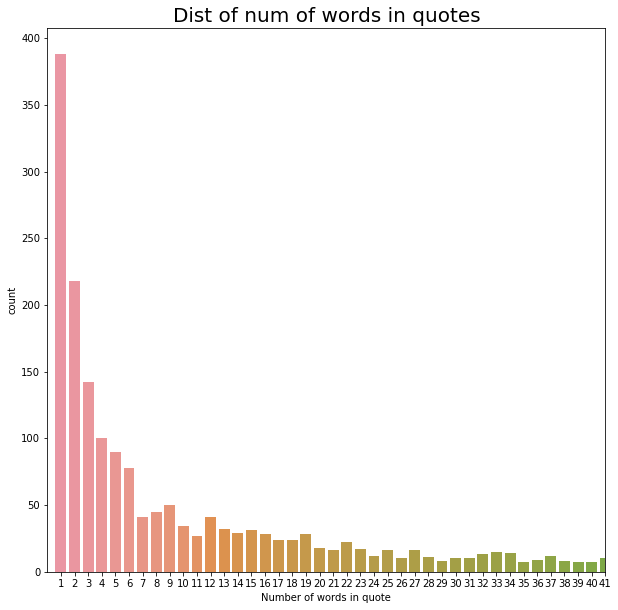

In [31]:
# make a plot
plt.figure(figsize=(10,10))
sns.countplot(quote_lengths[quote_lengths > 0])
plt.xlim(-1, 40)
plt.xlabel("Number of words in quote")
plt.title("Dist of num of words in quotes", fontsize = 20)

It looks like most of them are short and are used as scare quotes. Therefore I will just leave it as is. Anyway, I can't think of a way to sort through these quotes without access to the parent post.

# Basic model <a id='basic_model'></a>
I just want to try a basic model to see how well it does.

This basic model will:

1) stem the words

2) Use a TF-IDF vectorizer to vectorize the words

3) Use a Naive Bayes model to predict the result.

In [32]:
cond_df.head(3)

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id,has_cond,post_len,reply_len,cleaned_post,cleaned_reply
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj,1,37,17,"Well a guy is saying Barra, who has those grea...","Not condescending at all, jeez."
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp,1,314,230,"Well you're a stupid poopy-head.\n\nSee, I don...",Why would theories self-correct if they were a...
2,If I try and force down a breakfast I start ga...,Yes!\n\nPeople were so condescending about it ...,False,For me it's like temporarily having the flu. T...,> If I try and force down a breakfast I start ...,amphetaminesfailure,CowGiraffe,331,383,cuv97mf,cuvnb27,1,107,179,For me it's like temporarily having the flu. T...,Yes!\n\nPeople were so condescending about it ...


In [33]:
# split into train and validation data
X_train, X_val, y_train, y_val = train_test_split(cond_df[["cleaned_post", "cleaned_reply"]],
                                                  cond_df["label"])

In [35]:
# Pipeline classes need to implement fit and transform
class BaseClass:
    def __init__(self):
        pass
    # class must implement fit and xform
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return self

# first, it needs to lemmatize the word. I want to put this in the pipeline for convenience so
# wrap it in a class. I figured I might as well make it have some useful features since I might use
# it in the future.
class StemOrLemmatizer(BaseClass):
    
    def __init__(self, cols, choice = 'stem'):
        
        # if the user passes in only ONE column, just return a series not a DF
        # If you return a DF then TFIDF vectorizer gets angry, which is why I put this step in
        self._return_df = True
        if isinstance(cols, str):
            cols = [cols]
        if len(cols) == 1:
            self._return_df = False
        
        # It will only lemmatize the columns that you specify here
        self.cols_to_encode = cols
        
        if choice not in ["stem", "lemma"]:
            raise Exception("choice parameter can only be 'stem' or 'lemma'")
        self.choice = choice
        
    def transform(self, X, y=None):
        
        # create list of lists
        # the outer list is basically each column
        # the inner list is the entries in each column
        list_of_lists = []
        
        if self.choice == "stem":
            lemma = PorterStemmer()
        else:
            lemma = WordNetLemmatizer()
        
        #loop through all columns
        for i, col_name in enumerate(self.cols_to_encode):
            # add a new list (i.e. a new column)
            list_of_lists.append([])
            
            # loop through each column and append to list
            # not the most computationally efficient but w/e
            for sentence in X[col_name]:
                # loop through each word and lemmatize/stem it
                split_words = sentence.split()
                
                if self.choice == "stem":
                    split_words = [lemma.stem(s) for s in split_words]
                else:
                    split_words = [lemma.lemmatize(s) for s in split_words]
                    
                new_text = " ".join(split_words)
                
                # save this to the list
                list_of_lists[i].append(new_text)
                
        # if you only have one column, it should return a series (not DF)
        # this is to allow it to pass directly into TFIDF without causing errors
        if self._return_df == False:
            return pd.Series(list_of_lists[0])
        
        # well turns out my list was the wrong way, so just transpose it
        return pd.DataFrame(list_of_lists).transpose()

# and a class that dense-s it after vectorizing
class ToDense(BaseClass):
    def transform(self, data):
        return data.todense()

In [36]:
# now make a pipeline
basic_steps = [("stem", StemOrLemmatizer(cols = ["cleaned_post"])),
               ("tfidf", TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS)),
               ("dense", ToDense()),
               ("nbayes", MultinomialNB())]

basic_model = Pipeline(steps = basic_steps)

In [37]:
basic_model.fit(X_train, y_train)

Pipeline(steps=[('stem',
                 <__main__.StemOrLemmatizer object at 0x000002CE5E867DF0>),
                ('tfidf',
                 TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                     

In [38]:
# get predictions
val_predictions = basic_model.predict(X_val)

In [39]:
# conveniently there is this function
# so I don't have to figure out the row and col names
from sklearn.metrics import plot_confusion_matrix, accuracy_score

Text(0.5, 1.0, 'Confusion Matrix: TFIDF + Naive Bayes (Train Data)')

<Figure size 504x504 with 0 Axes>

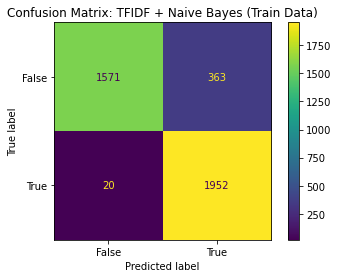

In [40]:
# plot the training data
plt.figure(figsize=(7,7))
plot_confusion_matrix(basic_model, X_train, y_train)
plt.title("Confusion Matrix: TFIDF + Naive Bayes (Train Data)")

In [41]:
accuracy_score(y_train, basic_model.predict(X_train))

0.9019457245263697

Text(0.5, 1.0, 'Confusion Matrix: TFIDF + Naive Bayes (Validation Data)')

<Figure size 504x504 with 0 Axes>

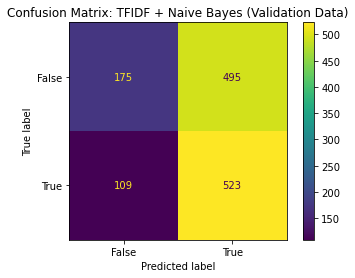

In [42]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(basic_model, X_val, y_val)
plt.title("Confusion Matrix: TFIDF + Naive Bayes (Validation Data)")

In [43]:
accuracy_score(y_val, val_predictions)

0.5360983102918587

It is obviously overfitting way too much so we should find better parameters using grid search. Although I'm not really sure if this counts as a basic model at this point.

In [44]:
params = {"tfidf__min_df" : [2, 3, 4],
          "tfidf__max_df" : [0.7, 0.8, 0.9]}

gridsearch = GridSearchCV(basic_model, param_grid = params, n_jobs = -1, cv = 5, verbose = 1)

In [45]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stem',
                                        <__main__.StemOrLemmatizer object at 0x000002CE5E867DF0>),
                                       ('tfidf',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',


In [46]:
gridsearch.best_score_

0.5773187368807123

In [47]:
gridsearch.best_estimator_

Pipeline(steps=[('stem',
                 <__main__.StemOrLemmatizer object at 0x000002CE000BD430>),
                ('tfidf',
                 TfidfVectorizer(max_df=0.7, min_df=4,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       

As expected, it's not very good. Next, we can try to add in the 'reply' column too. Since we saw earlier that the word 'condescending' in the reply is connected with the post being condescending, this most likely helps.

I will vectorize the post and the reply, then merge them together and use N. Bayes.

In [48]:
# use the same hyperparams from above

# Pipeline for the post column
steps_post = [("stem", StemOrLemmatizer(cols = ["cleaned_post"])),
               ("tfidf", TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS,
                                         min_df = 4,
                                         max_df = 0.7)),
               ("dense", ToDense())]

pipeline_post = Pipeline(steps_post)

# Pipeline for the reply column
steps_reply = [("stem", StemOrLemmatizer(cols = ["cleaned_reply"])),
               ("tfidf", TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS,
                                         min_df = 4,
                                         max_df = 0.7)),
               ("dense", ToDense())]

pipeline_reply = Pipeline(steps_reply)

# combine the post and reply
post_and_reply = FeatureUnion([("post", pipeline_post), ("reply", pipeline_reply)])

# add in a n. bayes to the end
combined_basic_model = Pipeline([("preprocess", post_and_reply), ("nbayes", MultinomialNB())])

In [49]:
combined_basic_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('post',
                                                 Pipeline(steps=[('stem',
                                                                  <__main__.StemOrLemmatizer object at 0x000002CE00009700>),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.7,
                                                                                  min_df=4,
                                                                                  stop_words=frozenset({'a',
                                                                                                        'about',
                                                                                                        'above',
                                                                                                        'across',
   

In [50]:
# get accuracy
print("test accuracy")
print(accuracy_score(y_train, combined_basic_model.predict(X_train)))
print("validation accuracy")
print(accuracy_score(y_val, combined_basic_model.predict(X_val)))

test accuracy
0.9070660522273426
validation accuracy
0.6328725038402457


We can see it's better, but it's overfitting (need to run grid search to get better hyperparams). Maybe I should try a different model, but that should be done in a different notebook. This was just to see what a baseline model will look like.

Save the cleaned data to be used later on.

In [202]:
# Uncomment to save
# cond_df.to_csv("./cond_data/added_features/balanced_train_more_features.csv")